## Gdz Elektrik Datathon 2023 - Time Series

📌 In this section, we will perform time series analysis by participating in the Gdz Elektrik Datathon 2023 competition.

**Important Note: This notebook is a summary of the work done by many different people. I would like to thank everyone who has contributed to the work done and I hope it will be useful to everyone competing and good ideas will come out.**

# Business Problem

📌 It is expected that an "energy distribution" estimation approach will be developed for grid centers under the responsibility of Gdz Elektrik with the presented data set of the participants.

# Dataset Story

**Files**:

* med.csv - Major Event Day dataset

* train.csv - Train dataset

* sample_submission.csv - Sample submission file

**Descriptions**:

* Major Event Day (MED.CSV): The day when the power outage time during the day exceeds the acceptable limit.Therefore, if there is an interruption, we expect the deviation of the estimated energy that day to be high. Because it could not be distributed due to the interruption.

* Dissipated Energy: Watt: Unit of active (useful) power.
MWh = MegaWatt hour

* 85% of the distributed energy is for İzmir and 15% for Manisa.

# Import Necessary Libraries

In [ ]:
import os
import itertools
import warnings
import numpy as np
import pandas as pd
pd.set_option("display.max_columns", None)
pd.set_option("display.width", 500)
pd.set_option("display.float_format", lambda x: "%.4f" % x)

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels.tsa.api as smt
import lightgbm as lgb
from prophet import Prophet
from sklearn.ensemble import RandomForestRegressor

warnings.filterwarnings("ignore")

# Import Dataset

In [ ]:
class cfg():
  notebook_name = 'GDZ-Elektrik-2023'
  data_dir = '/content/drive/MyDrive/Colab Notebooks/datasets/GDZ-Elektrik-2023/'
  dates = ['Tarih']
  target = 'Dağıtılan Enerji (MWh)'

In [ ]:
med = pd.read_csv(os.path.join(cfg.data_dir, 'med.csv'), parse_dates=cfg.dates)
df_train = pd.read_csv(os.path.join(cfg.data_dir, 'train.csv'), parse_dates=cfg.dates)
df_test = pd.read_csv(os.path.join(cfg.data_dir, 'sample_submission.csv'), parse_dates=cfg.dates)
df = pd.concat([df_train, df_test], axis=0)
df.head()

Tarih  Dağıtılan Enerji (MWh)
0 2018-01-01 00:00:00               1593.9442
1 2018-01-01 01:00:00               1513.9339
2 2018-01-01 02:00:00               1402.6126
3 2018-01-01 03:00:00               1278.5273
4 2018-01-01 04:00:00               1220.6977

In [ ]:
df.tail()

Tarih  Dağıtılan Enerji (MWh)
739 2022-08-31 19:00:00                  0.0000
740 2022-08-31 20:00:00                  0.0000
741 2022-08-31 21:00:00                  0.0000
742 2022-08-31 22:00:00                  0.0000
743 2022-08-31 23:00:00                  0.0000

In [ ]:
# Converting Dağıtılan Enerji (MWh) to log
df_train['Dağıtılan Enerji (MWh)'] = np.log1p(df_train['Dağıtılan Enerji (MWh)'].values)

# General Information About to the Dataset

In [ ]:
def check_df(dataframe,head=5):
  print("######################### Head #########################")
  print(dataframe.head(head))
  print("######################### Tail #########################")
  print(dataframe.tail(head))
  print("######################### Shape #########################")
  print(dataframe.shape)
  print("######################### Types #########################")
  print(dataframe.dtypes)
  print("######################### NA #########################")
  print(dataframe.isnull().sum())
  print("######################### Qurtiles #########################")
  print(dataframe.describe([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [ ]:
check_df(df)

######################### Head #########################
                Tarih  Dağıtılan Enerji (MWh)
0 2018-01-01 00:00:00               1593.9442
1 2018-01-01 01:00:00               1513.9339
2 2018-01-01 02:00:00               1402.6126
3 2018-01-01 03:00:00               1278.5273
4 2018-01-01 04:00:00               1220.6977
######################### Tail #########################
                  Tarih  Dağıtılan Enerji (MWh)
739 2022-08-31 19:00:00                  0.0000
740 2022-08-31 20:00:00                  0.0000
741 2022-08-31 21:00:00                  0.0000
742 2022-08-31 22:00:00                  0.0000
743 2022-08-31 23:00:00                  0.0000
######################### Shape #########################
(40896, 2)
######################### Types #########################
Tarih                     datetime64[ns]
Dağıtılan Enerji (MWh)           float64
dtype: object
######################### NA #########################
Tarih                     0
Dağıtılan Enerji

In [ ]:
print("Min Date: " , df[cfg.dates[0]].min(), " ,Max Date: ", df[cfg.dates[0]].max())

Min Date:  2018-01-01 00:00:00  ,Max Date:  2022-08-31 23:00:00


In [ ]:
train_month = df_train.copy()
train_month[cfg.dates[0]] = df_train[cfg.dates[0]].dt.to_period('M')
train_month = pd.DataFrame(train_month.groupby(cfg.dates[0])[cfg.target].sum())
train_month.head()

Dağıtılan Enerji (MWh)
Tarih                          
2018-01               5608.4200
2018-02               5019.0537
2018-03               5483.0942
2018-04               5254.1633
2018-05               5475.6088

# Visualizing the Time Series Simply

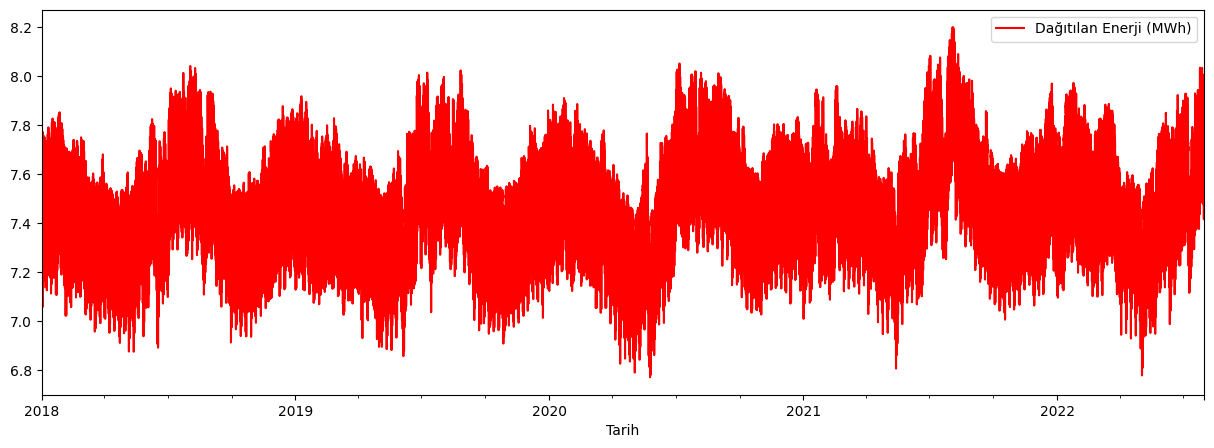

In [ ]:
df_train.set_index(cfg.dates[0]).plot(figsize=(15, 5), color='red')
plt.show()

# Time Series Structural Analysis

In [ ]:
def ts_decompose(y, model="additive"):
    
    # Stationary Test: Dickey-Fuller
    # "HO: Non-stationary"
    # "H1: Stationary"
    p_value = sm.tsa.stattools.adfuller(y)[1]
    if p_value < 0.05:
        is_istationary = (F"Result: Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    else:
        is_istationary = (F"Result: Non-Stationary (H0: non-stationary, p-value: {round(p_value, 3)})")
    
    result = seasonal_decompose(y, model=model)
    fig, axes = plt.subplots(4, 1, sharex=True, sharey=False)
    fig.set_figheight(10)
    fig.set_figwidth(15)

    axes[0].set_title("Decomposition for " + model + " model")
    axes[0].plot(y, 'k', label='Original ' + model)
    axes[0].legend(loc='upper left')

    axes[1].set_title(is_istationary)
    axes[1].plot(result.trend, label='Trend')
    axes[1].legend(loc='upper left')

    axes[2].plot(result.seasonal, 'g', label='Seasonality & Mean: ' + str(round(result.seasonal.mean(), 4)))
    axes[2].legend(loc='upper left')

    axes[3].plot(result.resid, 'r', label='Residuals & Mean: ' + str(round(result.resid.mean(), 4)))
    axes[3].legend(loc='upper left')
    plt.show(block=True)

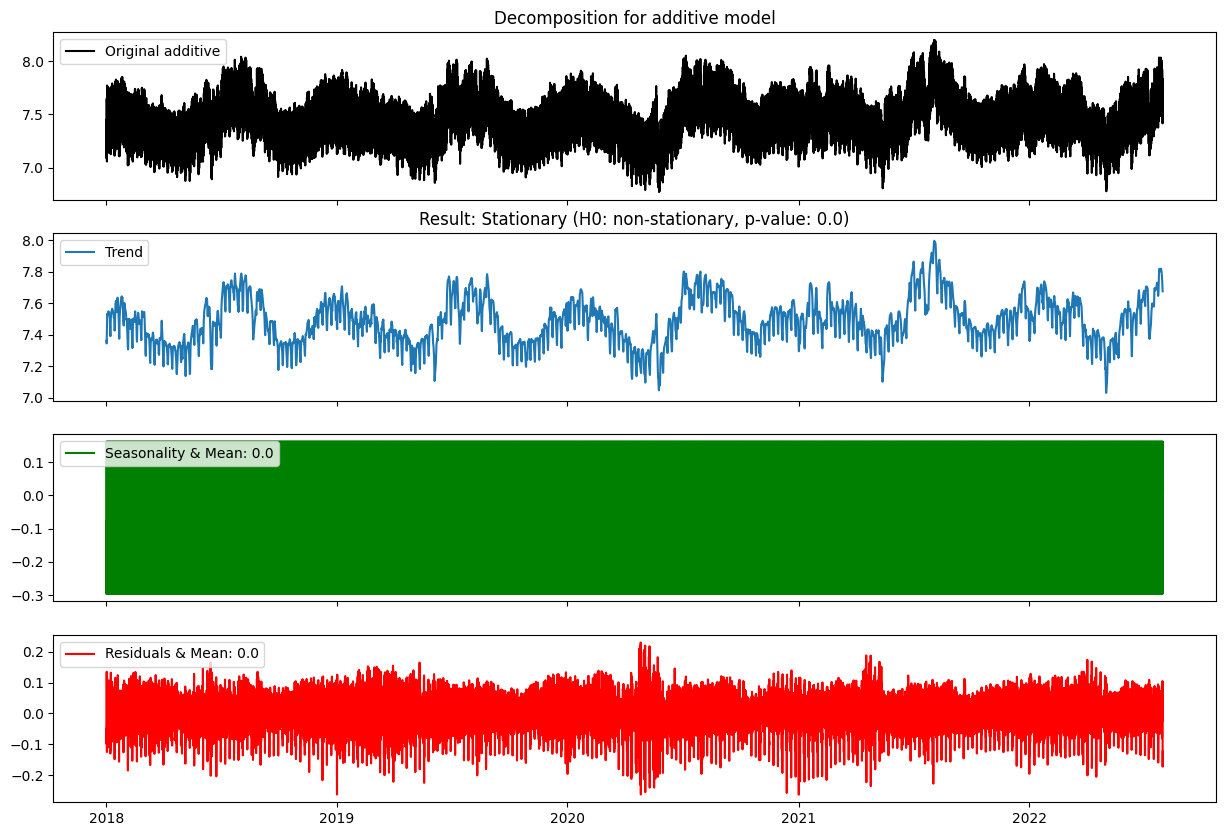

In [ ]:
ts_decompose(df_train.set_index(cfg.dates[0]))

# Splitting the Dataset

In [ ]:
# Using Holdut Method ===> Train: 40 Month and Test: 15 Month
train = train_month[:40]
test = train_month[40:]
print((len(train), len(test)))

(40, 15)


# SES: Single Exponential Smoothing

In [ ]:
def plot_model(train, test, y_pred, title):
  mae = mean_absolute_error(test, y_pred)
  train[cfg.target].plot(figsize=(15, 4), legend=True, label="TRAIN", title=f"{title}, MAE: {round(mae, 2)}")
  test[cfg.target].plot(legend=True, label="TEST")
  y_pred.plot(legend=True, label="PREDICTION")
  plt.show()

In [ ]:
def ses_optimizer(train, alphas, step):

    best_alpha, best_mae = None, float("inf")

    for alpha in alphas:
        ses_model = SimpleExpSmoothing(train).fit(smoothing_level=alpha)
        y_pred = ses_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)

        if mae < best_mae:
            best_alpha, best_mae = alpha, mae

    return best_alpha, best_mae

In [ ]:
def ses_model_tuning(train , test, step, title="Model Tuning - Single Exponential Smoothing"):
  alphas = np.arange(0.01, 1, 0.1)
  best_alpha, best_mae = ses_optimizer(train, alphas, step=step)
  final_model = SimpleExpSmoothing(train).fit(smoothing_level=best_alpha)
  y_pred = final_model.forecast(step)
  mae = mean_absolute_error(test, y_pred)
  plot_model(train, test, y_pred, title)

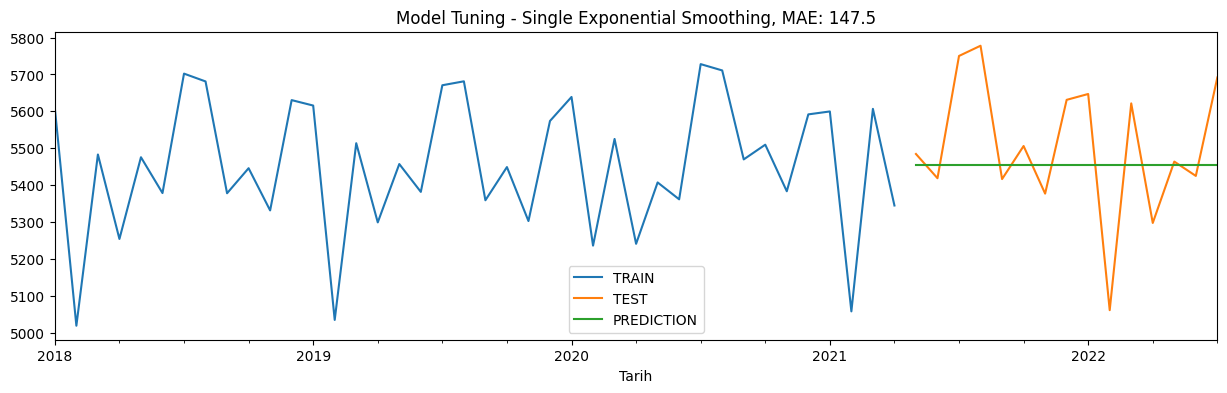

In [ ]:
ses_model_tuning(train, test, step=15)

# DES: Double Exponential Smoothing

In [ ]:
def des_optimizer(train, alphas, betas, trend, step):

    best_alpha, best_beta, best_mae = None, None, float("inf")

    for alpha in alphas:
        for beta in betas:
            des_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=alpha, smoothing_slope=beta)
            y_pred = des_model.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_alpha, best_beta, best_mae = alpha, beta, mae

    return best_alpha, best_beta, best_mae

In [ ]:
def des_model_tuning(train , test, step, trend, title="Model Tuning - Double Exponential Smoothing"):
  alphas = np.arange(0.01, 1, 0.10)
  betas = np.arange(0.01, 1, 0.10)
  best_alpha, best_beta, best_mae = des_optimizer(train, alphas, betas, trend=trend, step=step)
  final_model = ExponentialSmoothing(train, trend=trend).fit(smoothing_level=best_alpha, smoothing_slope=best_beta)
  y_pred = final_model.forecast(step)
  mae = mean_absolute_error(test, y_pred)
  plot_model(train, test, y_pred, title)

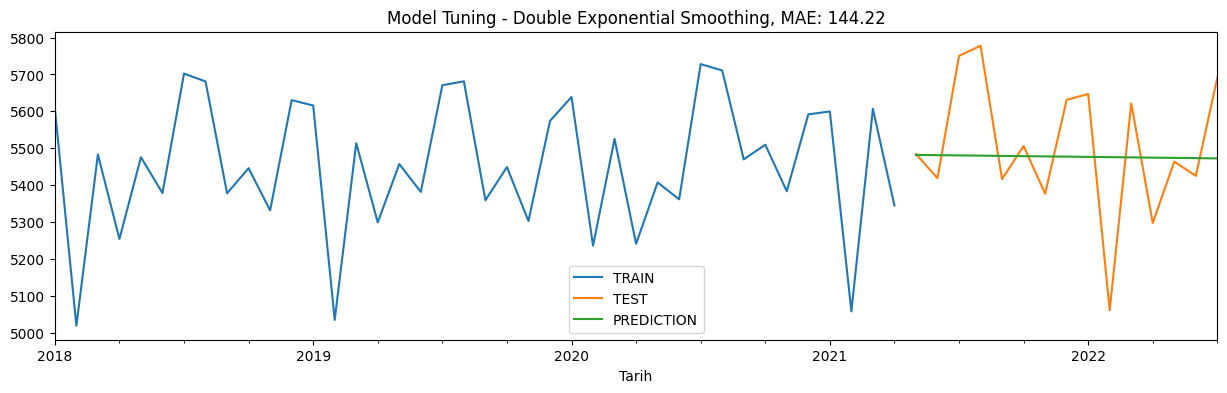

In [ ]:
des_model_tuning(train, test, step=15, trend='add')

# TES: Triple Exponential Smoothing

In [ ]:
def tes_optimizer(train, abg, trend, seasonal,  seasonal_periods, step):
    best_alpha, best_beta, best_gamma, best_mae = None, None, None, float("inf")
    for comb in abg:
        tes_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods).\
            fit(smoothing_level=comb[0], smoothing_slope=comb[1], smoothing_seasonal=comb[2])
        y_pred = tes_model.forecast(step)
        mae = mean_absolute_error(test, y_pred)
        if mae < best_mae:
            best_alpha, best_beta, best_gamma, best_mae = comb[0], comb[1], comb[2], mae

    return best_alpha, best_beta, best_gamma, best_mae

In [ ]:
def tes_model_tuning(train , test, step, trend, seasonal, seasonal_periods, title="Model Tuning - Triple Exponential Smoothing"):
  alphas = betas = gammas = np.arange(0.10, 1, 0.10)
  abg = list(itertools.product(alphas, betas, gammas))
  best_alpha, best_beta, best_gamma, best_mae = tes_optimizer(train, abg=abg, trend=trend, seasonal=seasonal, seasonal_periods=seasonal_periods, step=step)
  final_model = ExponentialSmoothing(train, trend=trend, seasonal=seasonal).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
  y_pred = final_model.forecast(step)
  mae = mean_absolute_error(test, y_pred)
  plot_model(train, test, y_pred, title)
  return best_alpha, best_beta, best_gamma, best_mae

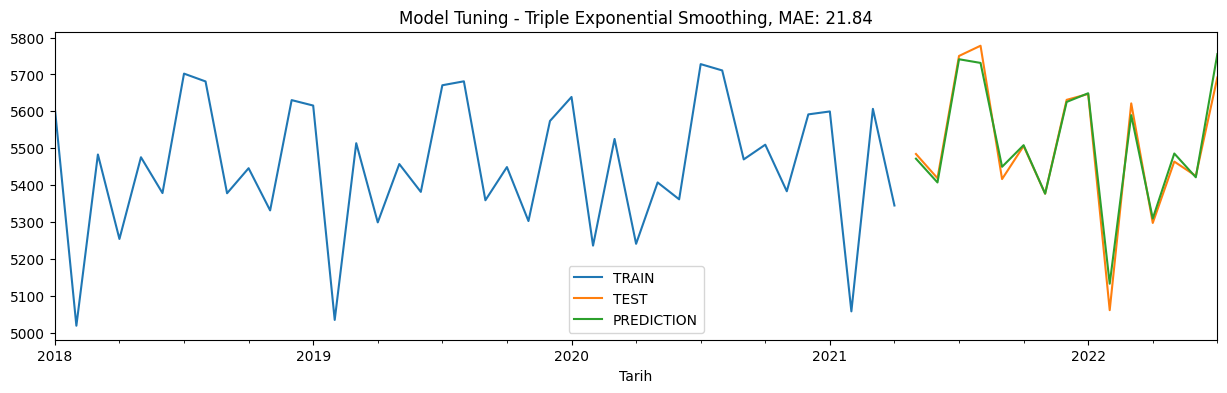

In [ ]:
best_alpha, best_beta, best_gamma, best_mae = tes_model_tuning(train, test, step=15, trend='add', seasonal='add', seasonal_periods=12)

In [ ]:
# TES Final Model

def tes_final_model(y, best_alpha, best_beta, best_gamma, step, trend='add', seasonal='add'):
  final_model = ExponentialSmoothing(y, trend=trend, seasonal=seasonal).fit(smoothing_level=best_alpha, smoothing_slope=best_beta, smoothing_seasonal=best_gamma)
  feature_predict = final_model.forecast(step)
  return feature_predict

In [ ]:
tes_predicts = tes_final_model(train_month, best_alpha, best_beta, best_gamma, step=1)
tes_predict = pd.DataFrame(tes_predicts)
tes_predict = tes_predict[0].rename('Total_Mwh')
tes_predict = pd.DataFrame(tes_predict)
tes_predict

Total_Mwh
2022-08  5731.3261

In [ ]:
df_train_tes = pd.read_csv(os.path.join(cfg.data_dir, 'train.csv'), parse_dates=cfg.dates)
df_train_tes

Tarih  Dağıtılan Enerji (MWh)
0     2018-01-01 00:00:00               1593.9442
1     2018-01-01 01:00:00               1513.9339
2     2018-01-01 02:00:00               1402.6126
3     2018-01-01 03:00:00               1278.5273
4     2018-01-01 04:00:00               1220.6977
...                   ...                     ...
40147 2022-07-31 19:00:00               2492.4895
40148 2022-07-31 20:00:00               2479.9582
40149 2022-07-31 21:00:00               2485.0169
40150 2022-07-31 22:00:00               2396.5743
40151 2022-07-31 23:00:00               2285.2528

[40152 rows x 2 columns]

In [ ]:
df_train_similar_tes = df_train[(df_train[cfg.dates[0]] >= "2021-08-01") & (df_train[cfg.dates[0]] < "2021-09-01")]
df_train_similar_tes

Tarih  Dağıtılan Enerji (MWh)
31392 2021-08-01 00:00:00                  7.8525
31393 2021-08-01 01:00:00                  7.7929
31394 2021-08-01 02:00:00                  7.7350
31395 2021-08-01 03:00:00                  7.6848
31396 2021-08-01 04:00:00                  7.6431
...                   ...                     ...
32131 2021-08-31 19:00:00                  7.8398
32132 2021-08-31 20:00:00                  7.8532
32133 2021-08-31 21:00:00                  7.8183
32134 2021-08-31 22:00:00                  7.7620
32135 2021-08-31 23:00:00                  7.7007

[744 rows x 2 columns]

In [ ]:
df_train_similar_tes['Hourly'] = df_train_similar_tes[cfg.target]/df_train_similar_tes[cfg.target].sum()
df_train_similar_tes['Predict'] = tes_predict['Total_Mwh'][0]
df_train_similar_tes['Result'] = df_train_similar_tes['Hourly']*df_train_similar_tes['Predict']
df_train_similar_tes

Tarih  Dağıtılan Enerji (MWh)  Hourly   Predict  Result
31392 2021-08-01 00:00:00                  7.8525  0.0014 5731.3261  7.7894
31393 2021-08-01 01:00:00                  7.7929  0.0013 5731.3261  7.7302
31394 2021-08-01 02:00:00                  7.7350  0.0013 5731.3261  7.6728
31395 2021-08-01 03:00:00                  7.6848  0.0013 5731.3261  7.6229
31396 2021-08-01 04:00:00                  7.6431  0.0013 5731.3261  7.5817
...                   ...                     ...     ...       ...     ...
32131 2021-08-31 19:00:00                  7.8398  0.0014 5731.3261  7.7768
32132 2021-08-31 20:00:00                  7.8532  0.0014 5731.3261  7.7900
32133 2021-08-31 21:00:00                  7.8183  0.0014 5731.3261  7.7554
32134 2021-08-31 22:00:00                  7.7620  0.0013 5731.3261  7.6995
32135 2021-08-31 23:00:00                  7.7007  0.0013 5731.3261  7.6387

[744 rows x 5 columns]

In [ ]:
df_submiss = pd.read_csv(os.path.join(cfg.data_dir, 'sample_submission.csv'), parse_dates=cfg.dates)
df_submiss[cfg.target]=list(np.expm1(df_train_similar_tes['Result']))
df_submiss.to_csv('submission-01.csv', index = False)
prediction_01 = df_submiss[cfg.target].values
df_submiss.head()

Tarih  Dağıtılan Enerji (MWh)
0 2022-08-01 00:00:00               2413.7683
1 2022-08-01 01:00:00               2274.9975
2 2022-08-01 02:00:00               2148.0513
3 2022-08-01 03:00:00               2043.5664
4 2022-08-01 04:00:00               1960.8813

# ARIMA: Autoregressive Integrated Moving Average

In [ ]:
def arima_optimizer_mae(train, orders, step):
    best_mae, best_params = float("inf"), None
    for order in orders:
        try:
            arima_model_result = ARIMA(train, order=order).fit()
            y_pred = arima_model_result.forecast(step)
            mae = mean_absolute_error(test, y_pred)
            if mae < best_mae:
                best_mae, best_params = mae, order
        except:
            continue
    return best_mae, best_params

In [ ]:
def arima_model_tuning_mae(train, test, step, title="Model Tuning - Autoregressive Integrated Moving Average"):
  p = d = q = range(0, 4)
  pdq = list(itertools.product(p, d, q))
  best_mae, best_params = arima_optimizer_mae(train, pdq, step)
  final_model = ARIMA(train, order=best_params).fit()
  y_pred = final_model.forecast(step)
  plot_model(train, test, y_pred, title)

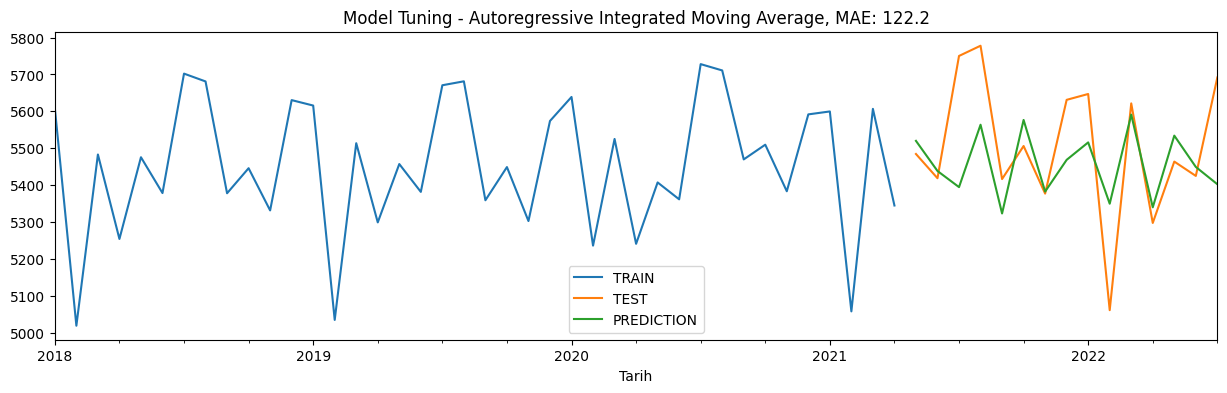

In [ ]:
arima_model_tuning_mae(train, test, step=15)

# SARIMA: Seasonal Autoregressive Integrated Moving Average

In [ ]:
def sarima_optimizer_mae(train, pdq, seasonal_pdq, step):
    best_mae, best_order, best_seasonal_order = float("inf"), None, None
    for param in pdq:
        for param_seasonal in seasonal_pdq:
            try:
                sarimax_model_results = SARIMAX(train, order=param, seasonal_order=param_seasonal).fit()
                y_pred_test = sarimax_model_results.get_forecast(step)
                y_pred = y_pred_test.predicted_mean
                mae = mean_absolute_error(test, y_pred)
                if mae < best_mae:
                    best_mae, best_order, best_seasonal_order = mae, param, param_seasonal
            except:
                continue
    return best_order, best_seasonal_order

In [ ]:
def sarima_model_tuning_mae(train, test, step, title="Model Tuning - Seasonal Autoregressive Integrated Moving Average"):
  p = d = q = range(0, 2)
  pdq = list(itertools.product(p, d, q))
  seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
  best_order, best_seasonal_order = sarima_optimizer_mae(train, pdq, seasonal_pdq, step)
  final_model = SARIMAX(train, order=best_order, seasonal_order=best_seasonal_order).fit()
  y_pred_test = final_model.get_forecast(step)
  y_pred = y_pred_test.predicted_mean
  plot_model(train, test, y_pred, title)
  return best_order, best_seasonal_order

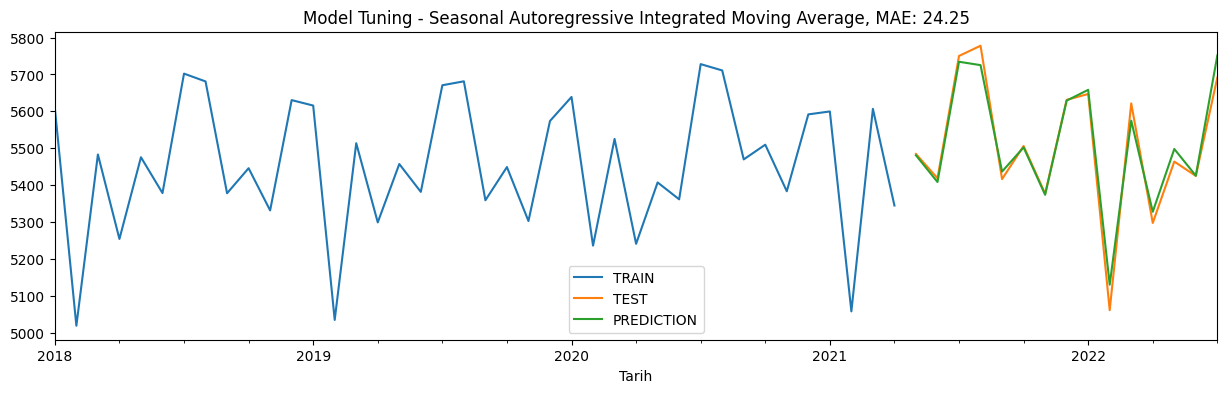

In [ ]:
best_order, best_seasonal_order = sarima_model_tuning_mae(train, test, step=15)

In [ ]:
# Sarima Final Model

def sarima_final_model(y, best_order, best_seasonal_order, step):
  final_model = SARIMAX(y, order=best_order, seasonal_order=best_seasonal_order).fit()
  feature_predict = final_model.get_forecast(step)
  feature_predict = feature_predict.predicted_mean
  return feature_predict

In [ ]:
predicts = sarima_final_model(train_month, best_order, best_seasonal_order, step=1)
predict = pd.DataFrame(predicts)
predict = predict[0].rename('Total_Mwh')
predict = pd.DataFrame(predict)
predict

Total_Mwh
2022-08  5749.4103

In [ ]:
df_train = pd.read_csv(os.path.join(cfg.data_dir, 'train.csv'), parse_dates=cfg.dates)
df_train

Tarih  Dağıtılan Enerji (MWh)
0     2018-01-01 00:00:00               1593.9442
1     2018-01-01 01:00:00               1513.9339
2     2018-01-01 02:00:00               1402.6126
3     2018-01-01 03:00:00               1278.5273
4     2018-01-01 04:00:00               1220.6977
...                   ...                     ...
40147 2022-07-31 19:00:00               2492.4895
40148 2022-07-31 20:00:00               2479.9582
40149 2022-07-31 21:00:00               2485.0169
40150 2022-07-31 22:00:00               2396.5743
40151 2022-07-31 23:00:00               2285.2528

[40152 rows x 2 columns]

In [ ]:
df_train_similar = df_train[(df_train[cfg.dates[0]] >= "2021-08-01") & (df_train[cfg.dates[0]] < "2021-09-01")]
df_train_similar

Tarih  Dağıtılan Enerji (MWh)
31392 2021-08-01 00:00:00               2571.2307
31393 2021-08-01 01:00:00               2422.2475
31394 2021-08-01 02:00:00               2286.0237
31395 2021-08-01 03:00:00               2173.9514
31396 2021-08-01 04:00:00               2085.2948
...                   ...                     ...
32131 2021-08-31 19:00:00               2538.8098
32132 2021-08-31 20:00:00               2572.9391
32133 2021-08-31 21:00:00               2484.6828
32134 2021-08-31 22:00:00               2348.5792
32135 2021-08-31 23:00:00               2208.8649

[744 rows x 2 columns]

In [ ]:
df_train_similar['Hourly'] = df_train_similar[cfg.target]/df_train_similar[cfg.target].sum()
df_train_similar['Predict'] = predict['Total_Mwh'][0]
df_train_similar['Result'] = df_train_similar['Hourly']*df_train_similar['Predict']
df_train_similar

Tarih  Dağıtılan Enerji (MWh)  Hourly   Predict  Result
31392 2021-08-01 00:00:00               2571.2307  0.0014 5749.4103  8.2413
31393 2021-08-01 01:00:00               2422.2475  0.0014 5749.4103  7.7638
31394 2021-08-01 02:00:00               2286.0237  0.0013 5749.4103  7.3272
31395 2021-08-01 03:00:00               2173.9514  0.0012 5749.4103  6.9680
31396 2021-08-01 04:00:00               2085.2948  0.0012 5749.4103  6.6838
...                   ...                     ...     ...       ...     ...
32131 2021-08-31 19:00:00               2538.8098  0.0014 5749.4103  8.1374
32132 2021-08-31 20:00:00               2572.9391  0.0014 5749.4103  8.2468
32133 2021-08-31 21:00:00               2484.6828  0.0014 5749.4103  7.9639
32134 2021-08-31 22:00:00               2348.5792  0.0013 5749.4103  7.5277
32135 2021-08-31 23:00:00               2208.8649  0.0012 5749.4103  7.0799

[744 rows x 5 columns]

In [ ]:
df_submission = pd.read_csv(os.path.join(cfg.data_dir, 'sample_submission.csv'), parse_dates=cfg.dates)
df_submission[cfg.target]=list(np.expm1(df_train_similar['Result']))
df_submission.to_csv('submission-02.csv', index = False)
prediction_02 = df_submission[cfg.target].values
df_submission.head()

Tarih  Dağıtılan Enerji (MWh)
0 2022-08-01 00:00:00               3793.6363
1 2022-08-01 01:00:00               2352.8812
2 2022-08-01 02:00:00               1520.1080
3 2022-08-01 03:00:00               1061.0738
4 2022-08-01 04:00:00                798.3631

# Lightgbm: Machine Learning Algorithms for Time Series Analysis

In [ ]:
# Feature Engineering

def create_date_features(df, date_column):
    df['hour'] = df[date_column].dt.strftime("%H")
    df["hour"] = df["hour"].astype('int64')
    df['date'] = df[date_column].dt.strftime("%Y-%m-%d")
    df["date"] = pd.to_datetime(df["date"])
    df['month'] = df[date_column].dt.month
    df['day_of_month'] = df[date_column].dt.day
    df['day_of_year'] = df[date_column].dt.dayofyear
    df['week_of_year'] = df[date_column].dt.weekofyear
    df['day_of_week'] = df[date_column].dt.dayofweek
    df['year'] = df[date_column].dt.year
    df["is_wknd"] = df[date_column].dt.weekday // 4
    df['is_month_start'] =df[date_column].dt.is_month_start.astype(int)
    df['is_month_end'] = df[date_column].dt.is_month_end.astype(int)
    df['quarter'] = df[date_column].dt.quarter
    df['is_quarter_start'] = df[date_column].dt.is_quarter_start.astype(int)
    df['is_quarter_end'] = df[date_column].dt.is_quarter_end.astype(int)
    df['is_year_start'] = df[date_column].dt.is_year_start.astype(int)
    df['is_year_end'] = df[date_column].dt.is_year_end.astype(int)
    return df

df_mla = create_date_features(df, cfg.dates[0])
df_mla["is_med"] = 0
df_mla.loc[df_mla["date"].isin(med.index), "is_med"] = 1
df_mla.head()

Tarih  Dağıtılan Enerji (MWh)  hour       date  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_med
0 2018-01-01 00:00:00               1593.9442     0 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0
1 2018-01-01 01:00:00               1513.9339     1 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0
2 2018-01-01 02:00:00               1402.6126     2 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0
3 2018-01-01 03:00:00               1278.5273     3 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0
4 2018-01-01 04:00:00               1220.6977     4 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0

In [ ]:
# Create Lag/Shifted Features

def random_noise(dataframe, scale=1.6):
  return np.random.normal(scale=scale, size=(len(dataframe), ))

def lag_features(dataframe, lags):
  for lag in lags:
    dataframe['energy_lag_' + str(lag)] = dataframe[cfg.target].transform(
        lambda x: x.shift(lag)) + random_noise(dataframe)
  return dataframe

one_year_ago_lag = [i for i in range(8760, 9505)]
two_year_ago_lag  = [i for i in range(17520, 18265)]
lag_list = one_year_ago_lag
lag_list.extend(two_year_ago_lag)

df_mla = lag_features(df_mla, lag_list)
df_mla = lag_features(df_mla, [91,92,170,171,172,173,174,175,176,177,178,179,180,181,182,183,184,185,186,187,188,189,190,
                       350,351,352,352,354,355,356,357,358,359,360,361,362,363,364,365,366,367,368,369,370,
                       538,539,540,541,542,
                       718,719,720,721,722])
df_mla.head()

Tarih  Dağıtılan Enerji (MWh)  hour       date  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_med  energy_lag_8760  energy_lag_8761  energy_lag_8762  energy_lag_8763  energy_lag_8764  energy_lag_8765  energy_lag_8766  energy_lag_8767  energy_lag_8768  energy_lag_8769  energy_lag_8770  energy_lag_8771  energy_lag_8772  energy_lag_8773  \
0 2018-01-01 00:00:00               1593.9442     0 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
1 2018-01-01 01:00:00               1513.9339     1 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
2 2018-01-01 02:00:00               1402.6126     2 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
3 2018-01-01 03:00:00               1278.5273     3 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
4 2018-01-01 04:00:00               1220.6977     4 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   

   energy_lag_8774  energy_lag_8775  energy_lag_8776  energy_lag_8777  energy_lag_8778  energy_lag_8779  energy_lag_8780  energy_lag_8781  energy_lag_8782  energy_lag_8783  energy_lag_8784  energy_lag_8785  energy_lag_8786  energy_lag_8787  energy_lag_8788  energy_lag_8789  energy_lag_8790  energy_lag_8791  energy_lag_8792  energy_lag_8793  energy_lag_8794  energy_lag_8795  energy_lag_8796  energy_lag_8797  energy_lag_8798  energy_lag_8799  energy_lag_8800  energy_lag_8801  energy_lag_8802  \
0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
1              NaN              NaN              NaN              NaN              Na

In [ ]:
# Rolling Mean Features

def roll_mean_features(dataframe, windows):
  for window in windows:
    dataframe['energy_roll_mean_' + str(window)] = dataframe[cfg.target].transform(
        lambda x: x.shift(1).rolling(window=window, min_periods=24, win_type='triang').mean()) + random_noise(dataframe)
  return dataframe

df_mla = roll_mean_features(df_mla, [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720, 8760, 17520])
df_mla.head()

Tarih  Dağıtılan Enerji (MWh)  hour       date  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_med  energy_lag_8760  energy_lag_8761  energy_lag_8762  energy_lag_8763  energy_lag_8764  energy_lag_8765  energy_lag_8766  energy_lag_8767  energy_lag_8768  energy_lag_8769  energy_lag_8770  energy_lag_8771  energy_lag_8772  energy_lag_8773  \
0 2018-01-01 00:00:00               1593.9442     0 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
1 2018-01-01 01:00:00               1513.9339     1 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
2 2018-01-01 02:00:00               1402.6126     2 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
3 2018-01-01 03:00:00               1278.5273     3 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
4 2018-01-01 04:00:00               1220.6977     4 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   

   energy_lag_8774  energy_lag_8775  energy_lag_8776  energy_lag_8777  energy_lag_8778  energy_lag_8779  energy_lag_8780  energy_lag_8781  energy_lag_8782  energy_lag_8783  energy_lag_8784  energy_lag_8785  energy_lag_8786  energy_lag_8787  energy_lag_8788  energy_lag_8789  energy_lag_8790  energy_lag_8791  energy_lag_8792  energy_lag_8793  energy_lag_8794  energy_lag_8795  energy_lag_8796  energy_lag_8797  energy_lag_8798  energy_lag_8799  energy_lag_8800  energy_lag_8801  energy_lag_8802  \
0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
1              NaN              NaN              NaN              NaN              Na

In [ ]:
# Exponentially Weighted Mean Features

def ewm_features(dataframe, alphas, lags):
  for alpha in alphas:
    for lag in lags:
      dataframe['energy_ewm_alpha_' + str(alpha).replace(".", "") + "_lag_" + str(lag)] = dataframe[cfg.target].transform(
          lambda x: x.shift(lag).ewm(alpha=alpha).mean())
  return dataframe

alphas = [0.95, 0.9, 0.8, 0.7, 0.5]
lags = [91,92,178,179,180,181,182,359,360,361,449,450,451,539,540,541,629,630,631,720, 8760, 17520]

df_mla = ewm_features(df_mla, alphas, lags)
df_mla.head()

Tarih  Dağıtılan Enerji (MWh)  hour       date  month  day_of_month  day_of_year  week_of_year  day_of_week  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_med  energy_lag_8760  energy_lag_8761  energy_lag_8762  energy_lag_8763  energy_lag_8764  energy_lag_8765  energy_lag_8766  energy_lag_8767  energy_lag_8768  energy_lag_8769  energy_lag_8770  energy_lag_8771  energy_lag_8772  energy_lag_8773  \
0 2018-01-01 00:00:00               1593.9442     0 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
1 2018-01-01 01:00:00               1513.9339     1 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
2 2018-01-01 02:00:00               1402.6126     2 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
3 2018-01-01 03:00:00               1278.5273     3 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
4 2018-01-01 04:00:00               1220.6977     4 2018-01-01      1             1            1             1            0  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   

   energy_lag_8774  energy_lag_8775  energy_lag_8776  energy_lag_8777  energy_lag_8778  energy_lag_8779  energy_lag_8780  energy_lag_8781  energy_lag_8782  energy_lag_8783  energy_lag_8784  energy_lag_8785  energy_lag_8786  energy_lag_8787  energy_lag_8788  energy_lag_8789  energy_lag_8790  energy_lag_8791  energy_lag_8792  energy_lag_8793  energy_lag_8794  energy_lag_8795  energy_lag_8796  energy_lag_8797  energy_lag_8798  energy_lag_8799  energy_lag_8800  energy_lag_8801  energy_lag_8802  \
0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
1              NaN              NaN              NaN              NaN              Na

In [ ]:
# One-Hot Encoding

df_mla = pd.get_dummies(df_mla, columns=['hour','day_of_week', 'month'])
df_mla.head()

Tarih  Dağıtılan Enerji (MWh)       date  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_med  energy_lag_8760  energy_lag_8761  energy_lag_8762  energy_lag_8763  energy_lag_8764  energy_lag_8765  energy_lag_8766  energy_lag_8767  energy_lag_8768  energy_lag_8769  energy_lag_8770  energy_lag_8771  energy_lag_8772  energy_lag_8773  energy_lag_8774  energy_lag_8775  \
0 2018-01-01 00:00:00               1593.9442 2018-01-01             1            1             1  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
1 2018-01-01 01:00:00               1513.9339 2018-01-01             1            1             1  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
2 2018-01-01 02:00:00               1402.6126 2018-01-01             1            1             1  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
3 2018-01-01 03:00:00               1278.5273 2018-01-01             1            1             1  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
4 2018-01-01 04:00:00               1220.6977 2018-01-01             1            1             1  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   

   energy_lag_8776  energy_lag_8777  energy_lag_8778  energy_lag_8779  energy_lag_8780  energy_lag_8781  energy_lag_8782  energy_lag_8783  energy_lag_8784  energy_lag_8785  energy_lag_8786  energy_lag_8787  energy_lag_8788  energy_lag_8789  energy_lag_8790  energy_lag_8791  energy_lag_8792  energy_lag_8793  energy_lag_8794  energy_lag_8795  energy_lag_8796  energy_lag_8797  energy_lag_8798  energy_lag_8799  energy_lag_8800  energy_lag_8801  energy_lag_8802  energy_lag_8803  energy_lag_8804  \
0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
1              NaN              NaN  

In [ ]:
# Converting Dağıtılan Enerji (MWh) to log
df_mla[cfg.target] = np.log1p(df_mla[cfg.target].values)
df_mla.head()

Tarih  Dağıtılan Enerji (MWh)       date  day_of_month  day_of_year  week_of_year  year  is_wknd  is_month_start  is_month_end  quarter  is_quarter_start  is_quarter_end  is_year_start  is_year_end  is_med  energy_lag_8760  energy_lag_8761  energy_lag_8762  energy_lag_8763  energy_lag_8764  energy_lag_8765  energy_lag_8766  energy_lag_8767  energy_lag_8768  energy_lag_8769  energy_lag_8770  energy_lag_8771  energy_lag_8772  energy_lag_8773  energy_lag_8774  energy_lag_8775  \
0 2018-01-01 00:00:00                  7.3746 2018-01-01             1            1             1  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
1 2018-01-01 01:00:00                  7.3231 2018-01-01             1            1             1  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
2 2018-01-01 02:00:00                  7.2468 2018-01-01             1            1             1  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
3 2018-01-01 03:00:00                  7.1542 2018-01-01             1            1             1  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
4 2018-01-01 04:00:00                  7.1080 2018-01-01             1            1             1  2018        0               1             0        1                 1               0              1            0       0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   

   energy_lag_8776  energy_lag_8777  energy_lag_8778  energy_lag_8779  energy_lag_8780  energy_lag_8781  energy_lag_8782  energy_lag_8783  energy_lag_8784  energy_lag_8785  energy_lag_8786  energy_lag_8787  energy_lag_8788  energy_lag_8789  energy_lag_8790  energy_lag_8791  energy_lag_8792  energy_lag_8793  energy_lag_8794  energy_lag_8795  energy_lag_8796  energy_lag_8797  energy_lag_8798  energy_lag_8799  energy_lag_8800  energy_lag_8801  energy_lag_8802  energy_lag_8803  energy_lag_8804  \
0              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN              NaN   
1              NaN              NaN  

In [ ]:
# Time-Based Validation Sets: Splitting Dataset

# Train set 
train = df_mla.loc[(df_mla[cfg.dates[0]] < "2021-08-01"), :]

# Validation set 
val = df_mla.loc[(df_mla["date"] >= "2021-08-01") & ((df_mla["date"] < "2021-09-01")), :]

cols = [col for col in train.columns if col not in ['Tarih', 'date', "Dağıtılan Enerji (MWh)", "year" ]]

Y_train = train[cfg.target]
X_train = train[cols]

Y_val = val[cfg.target]
X_val = val[cols]

print(Y_train.shape, X_train.shape, Y_val.shape, X_val.shape)

(31392,) (31392, 1730) (744,) (744, 1730)


In [ ]:
# MAPE: mean absolute percentage error
def mape(preds, target):
  mape = np.mean(np.abs((target - preds) / target))*100
  return mape

def lgbm_mape(preds, train_data):
    labels = train_data.get_label()
    mape_val = mape(np.expm1(preds), np.expm1(labels))
    return 'MAPE', mape_val, False

In [ ]:
# Create a Base Model: Lightgbm

lgb_params = {'metric': {'mae'},
              'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'num_boost_round': 1000,
              'early_stopping_rounds': 200,
              'nthread': -1}

lgbtrain = lgb.Dataset(data=X_train, label=Y_train, feature_name=cols)
lgbval = lgb.Dataset(data=X_val, label=Y_val, reference=lgbtrain, feature_name=cols)

model = lgb.train(lgb_params, lgbtrain, 
                  valid_sets=[lgbtrain, lgbval],
                  num_boost_round=lgb_params['num_boost_round'], 
                  early_stopping_rounds=lgb_params['early_stopping_rounds'],
                  verbose_eval=100)
y_pred_val = model.predict(X_val, num_iteration=model.best_iteration)
mape(np.expm1(y_pred_val), np.expm1(Y_val))

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 1.744843 seconds.
You can set `force_col_wise=true` to remove the overhead.
Training until validation scores don't improve for 200 rounds
[100]	training's l1: 0.0744467	valid_1's l1: 0.120066
[200]	training's l1: 0.0563394	valid_1's l1: 0.095431
[300]	training's l1: 0.0501111	valid_1's l1: 0.0931675
[400]	training's l1: 0.0466589	valid_1's l1: 0.0918328
[500]	training's l1: 0.0441893	valid_1's l1: 0.0919453
[600]	training's l1: 0.0422316	valid_1's l1: 0.0920506
Early stopping, best iteration is:
[424]	training's l1: 0.0460245	valid_1's l1: 0.0915959


8.687953040680426

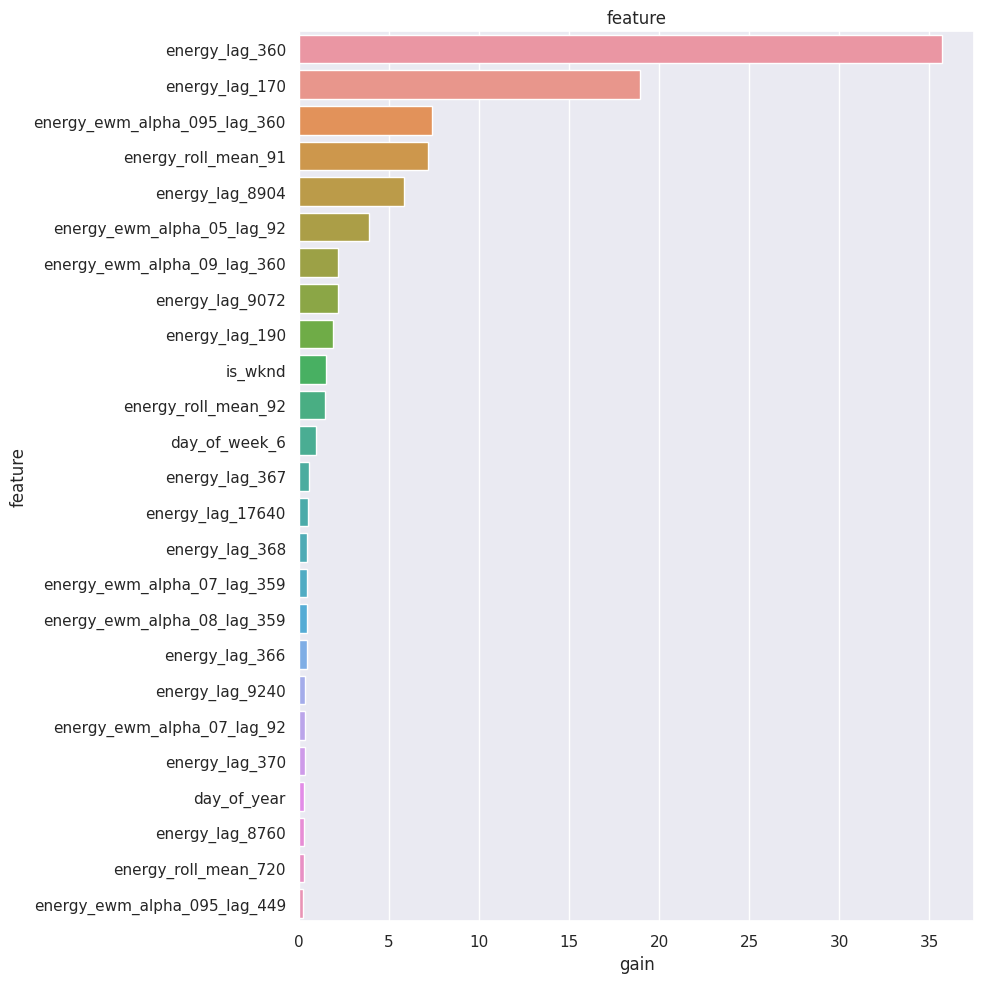

In [ ]:
# Feature Importance

def plot_lgb_importances(model, plot=False, num=10):
    gain = model.feature_importance('gain')
    feat_imp = pd.DataFrame({'feature': model.feature_name(),
                             'split': model.feature_importance('split'),
                             'gain': 100 * gain / gain.sum()}).sort_values('gain', ascending=False)
    if plot:
        plt.figure(figsize=(10, 10))
        sns.set(font_scale=1)
        sns.barplot(x="gain", y="feature", data=feat_imp[0:25])
        plt.title('feature')
        plt.tight_layout()
        plt.show()
    else:
        print(feat_imp.head(num))
    return feat_imp

feat_imp = plot_lgb_importances(model, plot=True, num=30)

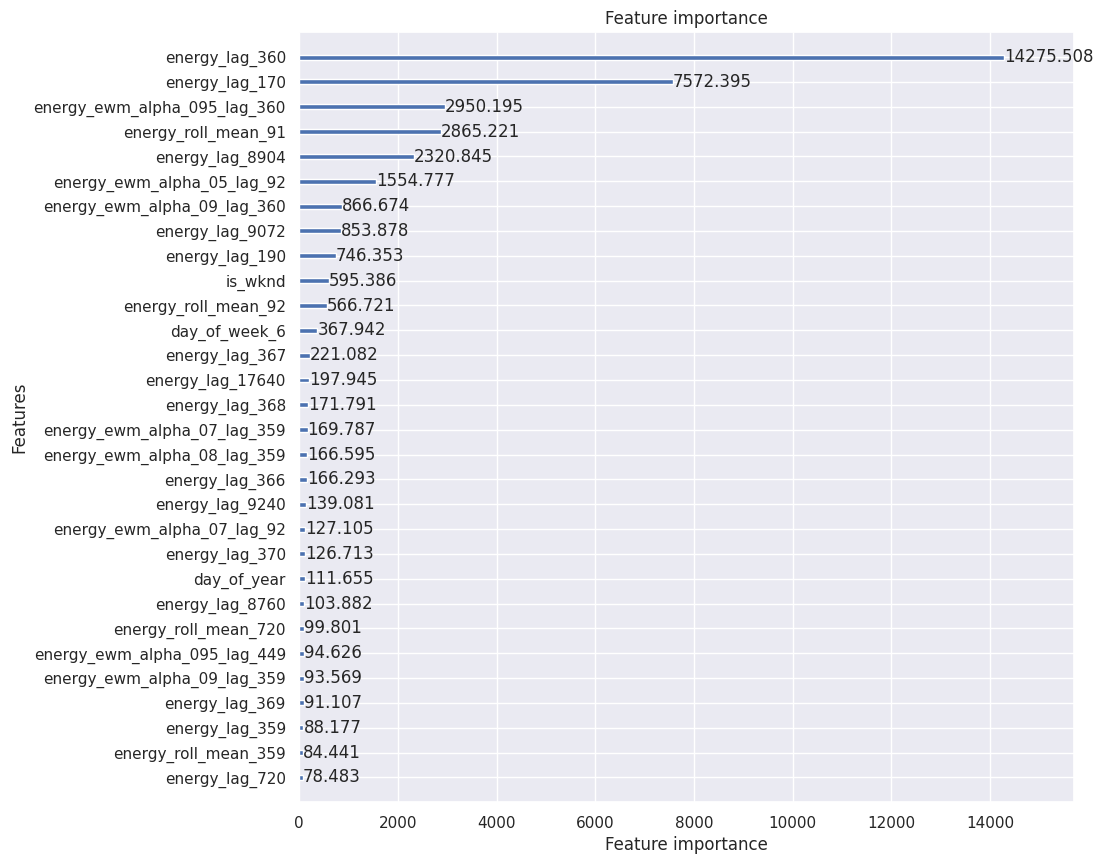

In [ ]:
lgb.plot_importance(model, max_num_features=30, figsize=(10, 10), importance_type="gain")
plt.show()

In [ ]:
# Remove zero importance features

importance_zero = feat_imp[feat_imp["gain"] == 0]["feature"].values
imp_feats = [col for col in cols if col not in importance_zero]
len(imp_feats)

299

In [ ]:
# Final Model

train = df_mla.loc[~(df_mla[cfg.target] == 0)]
Y_train = train[cfg.target]
X_train = train[imp_feats]

test = df_mla.loc[df_mla[cfg.target] == 0]
Y_test = test[cfg.target]
X_test = test[imp_feats]

lgb_params = {'num_leaves': 10,
              'learning_rate': 0.02,
              'feature_fraction': 0.8,
              'max_depth': 5,
              'verbose': 0,
              'nthread': -1,
              "num_boost_round": model.best_iteration}

lgbtrain_all = lgb.Dataset(data=X_train, label=Y_train, feature_name=imp_feats)
final_model = lgb.train(lgb_params, lgbtrain_all, num_boost_round=model.best_iteration)
test_preds = final_model.predict(X_test, num_iteration=model.best_iteration)

[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.155578 seconds.
You can set `force_col_wise=true` to remove the overhead.


In [ ]:
# Submission File: Kaggle Format

df_test[cfg.target] = np.expm1(test_preds)
df_test.to_csv("submission-03.csv", index=False)
prediction_03 = df_test[cfg.target].values
df_test.head()

Tarih  Dağıtılan Enerji (MWh)
0 2022-08-01 00:00:00               2304.4374
1 2022-08-01 01:00:00               2187.3449
2 2022-08-01 02:00:00               1992.6057
3 2022-08-01 03:00:00               1904.2530
4 2022-08-01 04:00:00               1865.3647

# Prophet: Using Prophet Method in Time Series Analysis


In [ ]:
# Import Dataset

med = pd.read_csv(os.path.join(cfg.data_dir, 'med.csv'), parse_dates=cfg.dates)
df_train = pd.read_csv(os.path.join(cfg.data_dir, 'train.csv'), parse_dates=cfg.dates)
df_test = pd.read_csv(os.path.join(cfg.data_dir, 'sample_submission.csv'), parse_dates=cfg.dates)
sub_df = df_test.copy()
df = pd.concat([df_train, df_test], axis=0)
df.head()

Tarih  Dağıtılan Enerji (MWh)
0 2018-01-01 00:00:00               1593.9442
1 2018-01-01 01:00:00               1513.9339
2 2018-01-01 02:00:00               1402.6126
3 2018-01-01 03:00:00               1278.5273
4 2018-01-01 04:00:00               1220.6977

In [ ]:
# Import External Dataset

hol = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/Calendar.csv', parse_dates=['CALENDAR_DATE'])
hol = hol[['CALENDAR_DATE','RAMADAN_FLAG','PUBLIC_HOLIDAY_FLAG']].rename(columns={'CALENDAR_DATE':'ds'})
hol['holiday'] = np.where((hol['RAMADAN_FLAG'] == 'Y') | (hol['PUBLIC_HOLIDAY_FLAG'] == 'Y'), 'TR-Holidays', 0)
hol = hol[['ds','holiday']]
hol = hol[hol['holiday'] == 'TR-Holidays']
hol.head()

ds      holiday
2  2024-12-29  TR-Holidays
3  2024-12-28  TR-Holidays
9  2024-12-22  TR-Holidays
10 2024-12-21  TR-Holidays
16 2024-12-15  TR-Holidays

In [ ]:
# Create Features

def create_features(df, label=None):
    df['date'] = df.index
    df['hour'] = df['date'].dt.hour
    df['dayofweek'] = df['date'].dt.dayofweek
    df['quarter'] = df['date'].dt.quarter
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year
    df['dayofyear'] = df['date'].dt.dayofyear
    df['dayofmonth'] = df['date'].dt.day
    df['weekofyear'] = df['date'].dt.weekofyear
    
    X = df[['hour','dayofweek','quarter','month','year',
           'dayofyear','dayofmonth','weekofyear']]
    if label:
        y = df[label]
        return X, y
    return X

X, y = create_features(df_train.set_index(cfg.dates[0]), label=cfg.target)

features_and_target = pd.concat([X, y], axis=1)

features_and_target.head()

hour  dayofweek  quarter  month  year  dayofyear  dayofmonth  weekofyear  Dağıtılan Enerji (MWh)
Tarih                                                                                                                
2018-01-01 00:00:00     0          0        1      1  2018          1           1           1               1593.9442
2018-01-01 01:00:00     1          0        1      1  2018          1           1           1               1513.9339
2018-01-01 02:00:00     2          0        1      1  2018          1           1           1               1402.6126
2018-01-01 03:00:00     3          0        1      1  2018          1           1           1               1278.5273
2018-01-01 04:00:00     4          0        1      1  2018          1           1           1               1220.6977

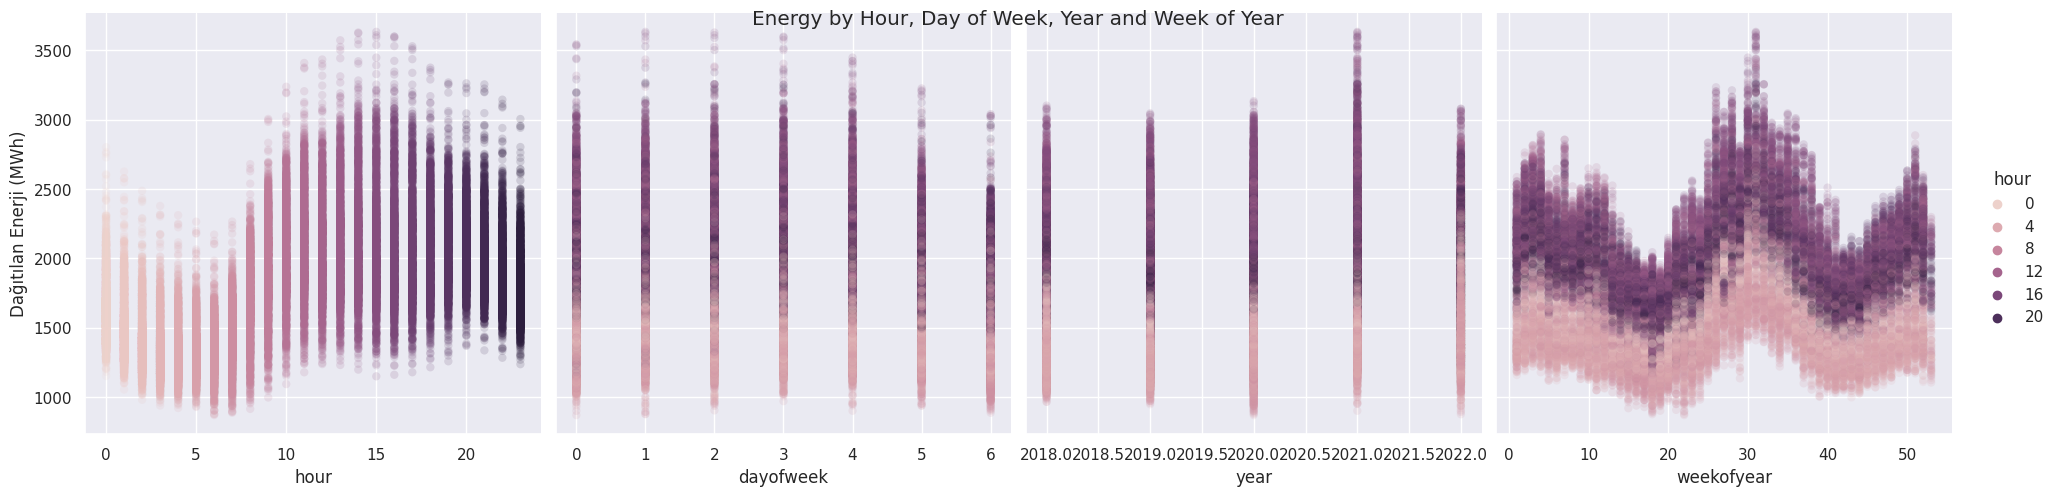

In [ ]:
sns.pairplot(features_and_target.dropna(),
             hue='hour',
             x_vars=['hour','dayofweek',
                     'year','weekofyear'],
             y_vars=cfg.target,
             height=5,
             plot_kws={'alpha':0.15, 'linewidth':0}
            )
plt.suptitle('Energy by Hour, Day of Week, Year and Week of Year')
plt.show()

In [ ]:
# Remove Outage

med['isover'] = True
df_train = pd.merge(df_train, 
                 med,
                 how='left',
                 on='Tarih')
df_train = df_train[df_train['isover'].isnull()].drop('isover', axis=1)

In [ ]:
df_train.head()

Tarih  Dağıtılan Enerji (MWh)
0 2018-01-01 00:00:00               1593.9442
1 2018-01-01 01:00:00               1513.9339
2 2018-01-01 02:00:00               1402.6126
3 2018-01-01 03:00:00               1278.5273
4 2018-01-01 04:00:00               1220.6977

In [ ]:
# Converting Dağıtılan Enerji (MWh) to log

df_train[cfg.target] = np.log1p(df_train[cfg.target])
df_train.head()

Tarih  Dağıtılan Enerji (MWh)
0 2018-01-01 00:00:00                  7.3746
1 2018-01-01 01:00:00                  7.3231
2 2018-01-01 02:00:00                  7.2468
3 2018-01-01 03:00:00                  7.1542
4 2018-01-01 04:00:00                  7.1080

In [ ]:
# Add Features on Model

def is_spring(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 3) & (date.month <= 5)

def is_summer(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 6) & (date.month <= 8)

def is_autumn(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 9) & (date.month <= 11)

def is_winter(ds):
    date = pd.to_datetime(ds)
    return (date.month >= 12) | (date.month <= 2)

def is_weekend(ds):
    date = pd.to_datetime(ds)
    return date.day_name in ('Saturday', 'Sunday')

# adding to train set
df_train['is_spring'] = df_train[cfg.dates[0]].apply(is_spring)
df_train['is_summer'] = df_train[cfg.dates[0]].apply(is_summer)
df_train['is_autumn'] = df_train[cfg.dates[0]].apply(is_autumn)
df_train['is_winter'] = df_train[cfg.dates[0]].apply(is_winter)
df_train['is_weekend'] = df_train[cfg.dates[0]].apply(is_weekend)
df_train['is_weekday'] = ~df_train[cfg.dates[0]].apply(is_weekend)

# adding to test set
df_test['is_spring'] = df_test[cfg.dates[0]].apply(is_spring)
df_test['is_summer'] = df_test[cfg.dates[0]].apply(is_summer)
df_test['is_autumn'] = df_test[cfg.dates[0]].apply(is_autumn)
df_test['is_winter'] = df_test[cfg.dates[0]].apply(is_winter)
df_test['is_weekend'] = df_test[cfg.dates[0]].apply(is_weekend)
df_test['is_weekday'] = ~df_test[cfg.dates[0]].apply(is_weekend)

In [ ]:
df_train.head()

Tarih  Dağıtılan Enerji (MWh)  is_spring  is_summer  is_autumn  is_winter  is_weekend  is_weekday
0 2018-01-01 00:00:00                  7.3746      False      False      False       True       False        True
1 2018-01-01 01:00:00                  7.3231      False      False      False       True       False        True
2 2018-01-01 02:00:00                  7.2468      False      False      False       True       False        True
3 2018-01-01 03:00:00                  7.1542      False      False      False       True       False        True
4 2018-01-01 04:00:00                  7.1080      False      False      False       True       False        True

In [ ]:
df_test.head()

Tarih  Dağıtılan Enerji (MWh)  is_spring  is_summer  is_autumn  is_winter  is_weekend  is_weekday
0 2022-08-01 00:00:00                  0.0000      False       True      False      False       False        True
1 2022-08-01 01:00:00                  0.0000      False       True      False      False       False        True
2 2022-08-01 02:00:00                  0.0000      False       True      False      False       False        True
3 2022-08-01 03:00:00                  0.0000      False       True      False      False       False        True
4 2022-08-01 04:00:00                  0.0000      False       True      False      False       False        True

In [ ]:
# Create Prophet Model

model = Prophet(holidays=hol)

model.add_seasonality(name='yearly', period=365.25, fourier_order=10)
model.add_seasonality(name='weekly_spring', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_spring')
model.add_seasonality(name='weekly_summer', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_summer')
model.add_seasonality(name='weekly_autumn', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_autumn')
model.add_seasonality(name='weekly_winter', 
                        period=7,
                        fourier_order=5, 
                        condition_name='is_winter')
model.add_seasonality(name='daily_spring',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_spring')
model.add_seasonality(name='daily_summer',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_summer')
model.add_seasonality(name='daily_autumn',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_autumn')
model.add_seasonality(name='daily_winter',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_winter')
model.add_seasonality(name='daily_weekend',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_weekend')
model.add_seasonality(name='daily_weekday',  
                        period=1,
                        fourier_order=5, 
                        condition_name='is_weekday')

model.fit(df_train.rename(columns={cfg.dates[0]:'ds',
                                cfg.target:'y'}))

INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4c8yk3c6/zcdsn7bt.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp4c8yk3c6/3g61se37.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.9/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=63437', 'data', 'file=/tmp/tmp4c8yk3c6/zcdsn7bt.json', 'init=/tmp/tmp4c8yk3c6/3g61se37.json', 'output', 'file=/tmp/tmp4c8yk3c6/prophet_modeljcyw8fke/prophet_model-20230422095840.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
09:58:40 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:01:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [ ]:
# Prediction

test_preds = model.predict(df=df_test.rename(columns={cfg.dates[0]:'ds',
                                                   cfg.target:'y'}))
test_preds.head()

ds  trend  yhat_lower  yhat_upper  trend_lower  trend_upper  TR-Holidays  TR-Holidays_lower  TR-Holidays_upper  additive_terms  additive_terms_lower  additive_terms_upper   daily  daily_lower  daily_upper  daily_autumn  daily_autumn_lower  daily_autumn_upper  daily_spring  daily_spring_lower  daily_spring_upper  daily_summer  daily_summer_lower  daily_summer_upper  daily_weekday  daily_weekday_lower  daily_weekday_upper  daily_weekend  daily_weekend_lower  \
0 2022-08-01 00:00:00 7.5351      7.5105      7.7089       7.5351       7.5351       0.0000             0.0000             0.0000          0.0738                0.0738                0.0738 -0.0400      -0.0400      -0.0400        0.0000              0.0000              0.0000        0.0000              0.0000              0.0000        0.0009              0.0009              0.0009        -0.0317              -0.0317              -0.0317         0.0000               0.0000   
1 2022-08-01 01:00:00 7.5351      7.4305      7.6319       7.5351       7.5351       0.0000             0.0000             0.0000         -0.0024               -0.0024               -0.0024 -0.0748      -0.0748      -0.0748        0.0000              0.0000              0.0000        0.0000              0.0000              0.0000       -0.0020             -0.0020             -0.0020        -0.0782              -0.0782              -0.0782         0.0000               0.0000   
2 2022-08-01 02:00:00 7.5351      7.3899      7.5881       7.5351       7.5351       0.0000             0.0000             0.0000         -0.0511               -0.0511               -0.0511 -0.1015      -0.1015      -0.1015        0.0000              0.0000              0.0000        0.0000              0.0000              0.0000        0.0013              0.0013              0.0013        -0.1115              -0.1115              -0.1115         0.0000               0.0000   
3 2022-08-01 03:00:00 7.5351      7.3674      7.5611       7.5351       7.5351       0.0000             0.0000             0.0000         -0.0759               -0.0759               -0.0759 -0.1216      -0.1216      -0.1216        0.0000              0.0000              0.0000        0.0000              0.0000              0.0000        0.0004              0.0004              0.0004        -0.1234              -0.1234              -0.1234         0.0000               0.0000   
4 2022-08-01 04:00:00 7.5351      7.3459      7.5349       7.5351       7.5351       0.0000             0.0000             0.0000         -0.1008               -0.1008               -0.1008 -0.1355      -0.1355      -0.1355        0.0000              0.0000              0.0000        0.0000              0.0000              0.0000       -0.0154             -0.0154             -0.0154        -0.1264              -0.1264              -0.1264         0.0000               0.0000   

   daily_weekend_upper  daily_winter  daily_winter_lower  daily_winter_upper  holidays  holidays_lower  holidays_upper  weekly  weekly_lower  weekly_upper  weekly_autumn  weekly_autumn_lower  weekly_autumn_upper  weekly_spring  weekly_spring_lower  weekly_spring_upper  weekly_summer  weekly_summer_lower  weekly_summer_upper  weekly_winter  weekly_winter_lower  weekly_winter_upper  yearly  yearly_lower  yearly_upper  multiplicative_terms  multiplicative_terms_lower  multiplicative_terms_upper  \
0               0.0000        0.0000              0.0000              0.0000    0.0000          0.0000          0.0000 -0.0497       -0.0497       -0.0497         0.0000               0.0000               0.0000         0.0000               0.0000               0.0000        -0.0131              -0.0131              -0.0131         0.0000               0.0000               0.0000  0.2074        0.2074        0.2074                0.0000                      0.0000                      0.0000   
1               0.0000        0.0000              0.0000              0.0000    0.0000          0.0000          0.0000 -0.0461

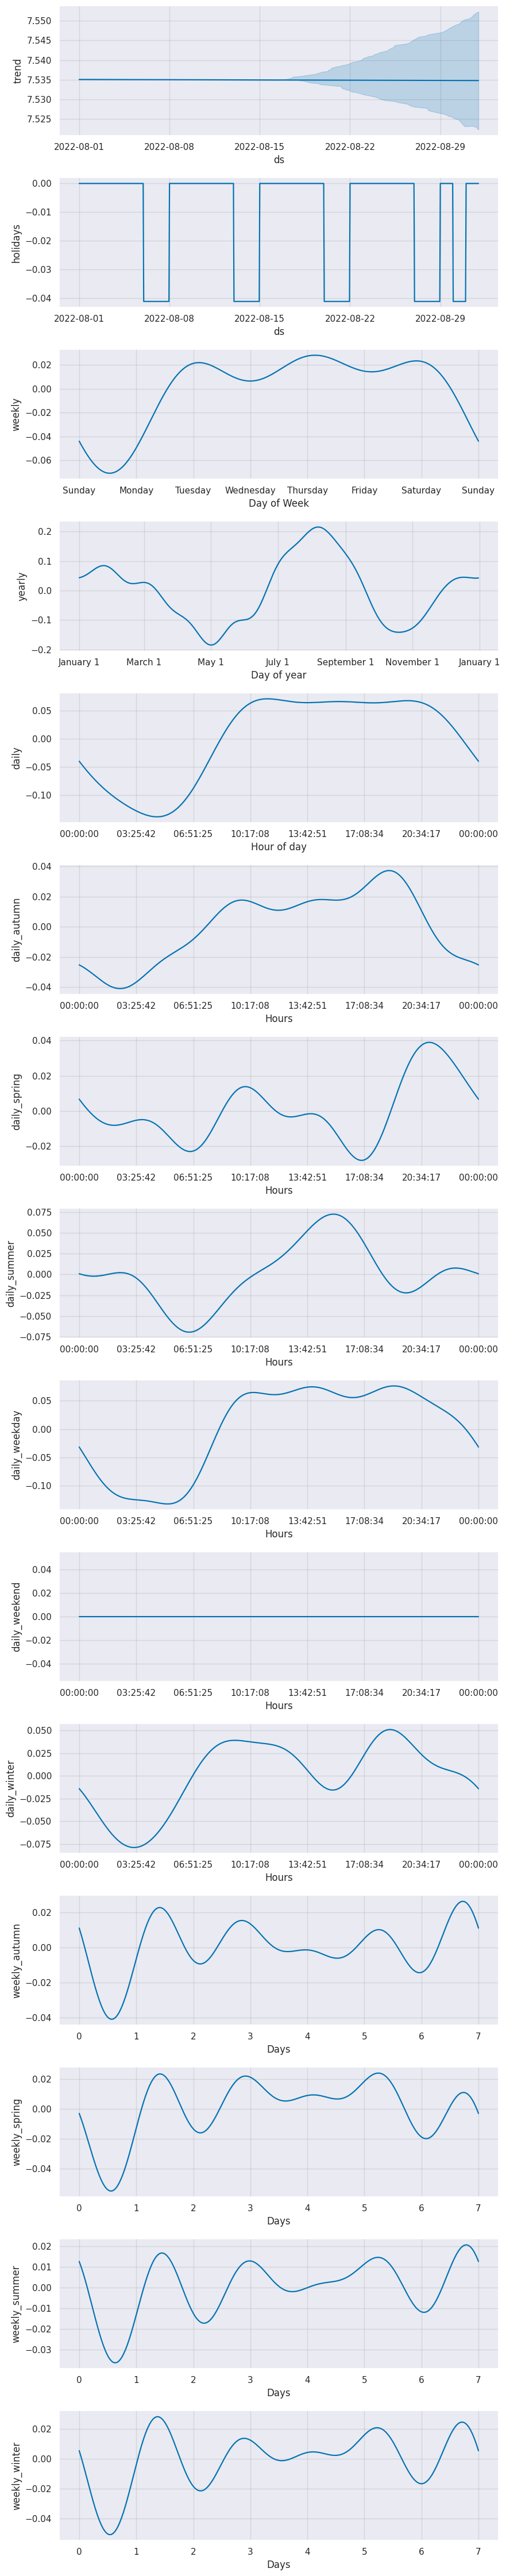

In [ ]:
# Plot Components

figure = model.plot_components(test_preds)

In [ ]:
# Submission File: Kaggle Format

test_preds['yhat'] = np.expm1(test_preds['yhat'])
sub_df[cfg.target] = test_preds['yhat'].values
sub_df.to_csv('submission-04.csv', index=False)
prediction_04 = test_preds['yhat'].values
sub_df.head()

Tarih  Dağıtılan Enerji (MWh)
0 2022-08-01 00:00:00               2015.0390
1 2022-08-01 01:00:00               1867.0701
2 2022-08-01 02:00:00               1778.3221
3 2022-08-01 03:00:00               1734.6700
4 2022-08-01 04:00:00               1692.0152

# Random Forest: Machine Learning Algorithms for Time Series Analysis

In [ ]:
# Import Datasets

med_df = pd.read_csv(os.path.join(cfg.data_dir, 'med.csv'), parse_dates=cfg.dates)
train_df = pd.read_csv(os.path.join(cfg.data_dir, 'train.csv'), parse_dates=cfg.dates)
submit_df = pd.read_csv(os.path.join(cfg.data_dir, 'sample_submission.csv'), parse_dates=cfg.dates)
calendar_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/Turkish_Calendar.csv',sep=(";"))
weather_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/datasets/Izmir_Weather.csv')

In [ ]:
def create_and_features_for_mla(med_df, train_df, submit_df, calendar_df, weather_df):
  med_df["Yıl"] = pd.to_datetime(med_df[cfg.dates[0]]).dt.year
  med_df["Ay"] = pd.to_datetime(med_df[cfg.dates[0]]).dt.month
  med_df["Gün"] = pd.to_datetime(med_df[cfg.dates[0]]).dt.day

  train_df["Yıl"] = pd.to_datetime(train_df[cfg.dates[0]]).dt.year
  train_df["Ay"] = pd.to_datetime(train_df[cfg.dates[0]]).dt.month
  train_df["Gün"] = pd.to_datetime(train_df[cfg.dates[0]]).dt.day
  train_df["Saat"] = pd.to_datetime(train_df[cfg.dates[0]]).dt.hour

  y_test = submit_df[cfg.target]
  submit_df["Yıl"] = pd.to_datetime(submit_df[cfg.dates[0]]).dt.year
  submit_df["Ay"] = pd.to_datetime(submit_df[cfg.dates[0]]).dt.month
  submit_df["Gün"] = pd.to_datetime(submit_df[cfg.dates[0]]).dt.day
  submit_df["Saat"] = pd.to_datetime(submit_df[cfg.dates[0]]).dt.hour
  submit_df["Kesintili Günler"]=0

  train_df = train_df.drop(cfg.dates[0], axis=1)
  submit_df = submit_df.drop(cfg.dates[0], axis=1)
  med_df = med_df.drop(cfg.dates[0], axis=1)

  med_df[['Yıl', 'Ay', 'Gün']] = med_df[['Yıl', 'Ay', 'Gün']].astype(int)
  train_df['Kesintili Günler'] = train_df.apply(lambda row: int((row[['Yıl', 'Ay', 'Gün']] == med_df[['Yıl', 'Ay', 'Gün']]).all(axis=1).any()), axis=1)

  new_df = calendar_df.iloc[853:2557]

  new_df = new_df.drop("SEASON_SK", axis=1)
  new_df = new_df.drop("SPECIAL_DAY_SK", axis=1)
  new_df = new_df.drop("SPECIAL_DAY_SK2", axis=1)

  new_df["WEEKEND_FLAG"] = new_df["WEEKEND_FLAG"].replace(["N"],0)
  new_df["WEEKEND_FLAG"] = new_df["WEEKEND_FLAG"].replace(["Y"],1)
  new_df["RAMADAN_FLAG"] = new_df["RAMADAN_FLAG"].replace(["N"],0)
  new_df["RAMADAN_FLAG"] = new_df["RAMADAN_FLAG"].replace(["Y"],1)
  new_df["PUBLIC_HOLIDAY_FLAG"] = new_df["PUBLIC_HOLIDAY_FLAG"].replace(["N"],0)
  new_df["PUBLIC_HOLIDAY_FLAG"] = new_df["PUBLIC_HOLIDAY_FLAG"].replace(["Y"],1)

  new_df.rename(columns={'DAY_OF_MONTH': 'Gün'}, inplace=True)
  new_df.rename(columns={'DAY_OF_WEEK_SK': 'Haftanın Günü'}, inplace=True)
  new_df.rename(columns={'QUARTER_OF_YEAR': 'Sezon'}, inplace=True)
  new_df.rename(columns={'WEEKEND_FLAG': 'Haftasonu - Haftaiçi'}, inplace=True)
  new_df.rename(columns={'WEEK_OF_YEAR': 'Yılın kaçıncı haftası'}, inplace=True)
  new_df.rename(columns={'RAMADAN_FLAG': 'Ramazan'}, inplace=True)
  new_df.rename(columns={'RELIGIOUS_DAY_FLAG_SK': 'Dini Gün'}, inplace=True)
  new_df.rename(columns={'NATIONAL_DAY_FLAG_SK': 'Ulusal Gün'}, inplace=True)
  new_df.rename(columns={'PUBLIC_HOLIDAY_FLAG': 'Resmi tatil'}, inplace=True)

  new_df["Ay"] = pd.to_datetime(new_df["CALENDAR_DATE"], format="%d.%m.%Y").dt.month
  new_df["Yıl"] = pd.to_datetime(new_df["CALENDAR_DATE"], format="%d.%m.%Y").dt.year

  new_df_submit=new_df.iloc[0:31]
  new_df_train=new_df.iloc[31:1704]

  merged_df = pd.merge(train_df, new_df_train, on=["Yıl", "Ay", "Gün"])
  merged_df2 = pd.merge(submit_df, new_df_submit, on=["Yıl", "Ay", "Gün"])

  hava_train=weather_df.iloc[0:40152]
  hava_test = weather_df.iloc[40152:40896].reset_index(drop=True)
  Last_train=pd.concat([merged_df, hava_train],axis=1)
  Last_test=pd.concat([merged_df2, hava_test],axis=1)
  Last_train = Last_train.drop('location', axis=1)
  Last_test = Last_test.drop('location', axis=1)

  moonrise_times = pd.to_datetime(Last_train['moonrise'], format='%I:%M %p', errors='coerce')
  moonrise_hours = moonrise_times.dt.hour
  Last_train['moonrise']=moonrise_hours
  moonset_times = pd.to_datetime(Last_train['moonset'], format='%I:%M %p', errors='coerce')
  moonset_hours = moonset_times.dt.hour
  Last_train['moonset']=moonset_hours
  sunrise_times = pd.to_datetime(Last_train['sunrise'], format='%I:%M %p', errors='coerce')
  sunrise_hours = sunrise_times.dt.hour
  Last_train['sunrise']=sunrise_hours
  sunset_times = pd.to_datetime(Last_train['sunset'], format='%I:%M %p', errors='coerce')
  sunset_hours = sunset_times.dt.hour
  Last_train['sunset']=sunset_hours

  moonrise_times = pd.to_datetime(Last_test['moonrise'], format='%I:%M %p', errors='coerce')
  moonrise_hours = moonrise_times.dt.hour
  Last_test['moonrise']=moonrise_hours
  moonset_times = pd.to_datetime(Last_test['moonset'], format='%I:%M %p', errors='coerce')
  moonset_hours = moonset_times.dt.hour
  Last_test['moonset']=moonset_hours
  sunrise_times = pd.to_datetime(Last_test['sunrise'], format='%I:%M %p', errors='coerce')
  sunrise_hours = sunrise_times.dt.hour
  Last_test['sunrise']=sunrise_hours
  sunset_times = pd.to_datetime(Last_test['sunset'], format='%I:%M %p', errors='coerce')
  sunset_hours = sunset_times.dt.hour
  Last_test['sunset']=sunset_hours

  X_train=Last_train.drop(cfg.target, axis=1)
  X_train=X_train.drop("CALENDAR_DATE", axis=1)
  X_train=X_train.drop('date_time', axis=1)
  X_train=X_train.drop('moonrise', axis=1)
  X_train=X_train.drop('moonset', axis=1)
  y_train=merged_df[cfg.target]
  X_test=Last_test.drop(cfg.target, axis=1)
  X_test=X_test.drop("CALENDAR_DATE", axis=1)
  X_test=X_test.drop("date_time", axis=1)
  X_test=X_test.drop("moonrise", axis=1)
  X_test=X_test.drop("moonset", axis=1)

  return X_train, X_test, y_train, y_test

In [ ]:
X_train, X_test, y_train, y_test = create_and_features_for_mla(med_df, train_df, submit_df, calendar_df, weather_df)

In [ ]:
X_train.head()

Yıl  Ay  Gün  Saat  Kesintili Günler  Haftanın Günü  Sezon  Haftasonu - Haftaiçi  Yılın kaçıncı haftası  Ramazan  Dini Gün  Ulusal Gün  Resmi tatil  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  moon_illumination  sunrise  sunset  DewPointC  FeelsLikeC  HeatIndexC  WindChillC  WindGustKmph  cloudcover  humidity  precipMM  pressure  tempC  visibility  winddirDegree  windspeedKmph
0  2018   1    1     0                 0              1      1                     0                      1        0       100         206            1        11         6        0.0000   9.7000        3                 97        8      18          3           5           7           5            23           5        78    0.0000      1020      7          10            343             10
1  2018   1    1     1                 0              1      1                     0                      1        0       100         206            1        11         6        0.0000   9.7000        3                 97        8      18          3           5           7           5            22           5        77    0.0000      1020      7          10            238              9
2  2018   1    1     2                 0              1      1                     0                      1        0       100         206            1        11         6        0.0000   9.7000        3                 97        8      18          3           4           6           4            21           5        77    0.0000      1020      6          10            132             12
3  2018   1    1     3                 0              1      1                     0                      1        0       100         206            1        11         6        0.0000   9.7000        3                 97        8      18          2           4           6           4            20           5        76    0.0000      1020      6          10             26             11
4  2018   1    1     4                 0              1      1                     0                      1        0       100         206            1        11         6        0.0000   9.7000        3                 97        8      18          2           4           6           4            19           5        77    0.0000      1020      6          10             45             11

In [ ]:
y_train.head()

0   1593.9442
1   1513.9339
2   1402.6126
3   1278.5273
4   1220.6977
Name: Dağıtılan Enerji (MWh), dtype: float64

In [ ]:
y_test.head()

0   0.0000
1   0.0000
2   0.0000
3   0.0000
4   0.0000
Name: Dağıtılan Enerji (MWh), dtype: float64

In [ ]:
X_test.head()

Yıl  Ay  Gün  Saat  Kesintili Günler  Haftanın Günü  Sezon  Haftasonu - Haftaiçi  Yılın kaçıncı haftası  Ramazan  Dini Gün  Ulusal Gün  Resmi tatil  maxtempC  mintempC  totalSnow_cm  sunHour  uvIndex  moon_illumination  sunrise  sunset  DewPointC  FeelsLikeC  HeatIndexC  WindChillC  WindGustKmph  cloudcover  humidity  precipMM  pressure  tempC  visibility  winddirDegree  windspeedKmph
0  2022   8    1     0                 0              1      3                     0                     32        0       100         200            0        29        23        0.0000  11.6000        7                 22        6      20         18          27          27          25            32           0        70    0.0000      1006     25          10            352             15
1  2022   8    1     1                 0              1      3                     0                     32        0       100         200            0        29        23        0.0000  11.6000        7                 22        6      20         18          26          26          24            34           0        71    0.0000      1006     24          10            353             16
2  2022   8    1     2                 0              1      3                     0                     32        0       100         200            0        29        23        0.0000  11.6000        7                 22        6      20         18          25          25          24            36           0        72    0.0000      1006     24          10            354             17
3  2022   8    1     3                 0              1      3                     0                     32        0       100         200            0        29        23        0.0000  11.6000        7                 22        6      20         18          25          25          23            37           0        73    0.0000      1006     23          10            355             18
4  2022   8    1     4                 0              1      3                     0                     32        0       100         200            0        29        23        0.0000  11.6000        7                 22        6      20         18          25          25          23            36           0        72    0.0000      1006     23          10            237             18

In [ ]:
model_rf = RandomForestRegressor(n_estimators=1000, random_state=42)
model_rf.fit(X_train, y_train)
y_pred_rf = model_rf.predict(X_test)

In [ ]:
submission_rf = pd.read_csv(os.path.join(cfg.data_dir, 'sample_submission.csv'), parse_dates=cfg.dates)
submission_rf[cfg.target]=y_pred_rf
submission_rf.to_csv("submission-05.csv",index=False)
prediction_05 = model_rf.predict(X_test)

# Final Submission

In [ ]:
y_pred = prediction_05*0.6 + prediction_04*0.4
df_submission = pd.read_csv(os.path.join(cfg.data_dir, 'sample_submission.csv'), parse_dates=cfg.dates)
df_submission[cfg.target] = y_pred
df_submission.to_csv('submission-finall.csv', index=False)
df_submission

Tarih  Dağıtılan Enerji (MWh)
0   2022-08-01 00:00:00               2103.4631
1   2022-08-01 01:00:00               1920.4791
2   2022-08-01 02:00:00               1814.0621
3   2022-08-01 03:00:00               1763.3297
4   2022-08-01 04:00:00               1714.6997
..                  ...                     ...
739 2022-08-31 19:00:00               2544.6093
740 2022-08-31 20:00:00               2452.4605
741 2022-08-31 21:00:00               2400.1148
742 2022-08-31 22:00:00               2326.5641
743 2022-08-31 23:00:00               2189.5390

[744 rows x 2 columns]